In [44]:
import nltk,re,time,umap,collections,wordcloud,sys,os
sys.path.append('../')
from sentence_transformers import SentenceTransformer,models
import plotly.express as px
import pandas as pd
import mlflow
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from modules import utils
from modules import modeling

from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
%reload_ext utils
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json 

from scipy.spatial.distance import pdist, squareform

from flair.models import SequenceTagger
from flair.data import Sentence

TOP_N = 100


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Flair-based NER 

In [2]:
tagger = SequenceTagger.load('de-ner-germeval')
sentence = Sentence('George Washington ging nach Washington.')
tagger.predict(sentence)

2020-10-25 20:09:54,947 loading file /Users/tomasztkaczyk/.flair/models/de-ner-germeval-0.4.1.pt


## Load the Google's NER Tags for the labeled articles 

In [3]:
labeled = pd.read_csv("../data/raw_article_entities.csv",header=None,names=["_id","article_id","kicker_headline","text_ne","seo_title_ne","created_at_ne","updated_at","parset"])

labeled.drop(["parset","updated_at","_id"],axis=1,inplace=True)
labeled=labeled.set_index("article_id")
print(labeled.shape)
labeled.head(1)

(240, 4)


,kicker_headline,text_ne,seo_title_ne,created_at_ne
article_id,,,,
080f9e0033f23540881fd07ecbf503e9066c5151ddb82287852b1badfcad4e7d,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-09 15:52:04


# Load the labeled Clusters and join them with NER from HUD DB

In [4]:
X = utils.load_labeled_data()
X.drop(["site","entities_analyzed","updated_at"],inplace=True,axis="columns")

X['mix'] =  X['headline'] +" "+ X["seo_title"].apply(utils.remove_seo_title_marker) #+ X["text"].apply(lambda x: " ".join(x.split(" ")[:150]))
#pdf_mix = utils.preprocess_text(X,col="mix")
pdf_mix = X["mix"].values
X = X.join(labeled,how='right')
X.drop_duplicates(subset='headline',inplace=True)
pdf= utils.preprocess_text(X,"text")

X.tail(5)

,labels,headline,seo_title,text,created_at_date,created_at,mix,kicker_headline,text_ne,seo_title_ne,created_at_ne
faae5f2ef63c63baae47bc98fb1cb2a40274156a3508a9b2b6f702e0d1ba40f1,22,Finanzielle Engpässe: Wie stark belastet Coron...,Wie stark belastet Corona unseren Geldbeutel?,Die Corona-Pandemie macht sich seit Monaten im...,9/13/20,2020-09-13 21:55:15,Finanzielle Engpässe: Wie stark belastet Coron...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-13 21:56:04
fab9f708d9ba4e68959eea74ace58df6fee0449bdb6e713897db3eb14e1206b5,29,Corona in Garmisch-Partenkirchen | Pub-Bertrei...,Pub-Betreiber total fertig: „Das ist eine Kata...,Eine 26-jährige Super-Spreaderin verursachte a...,9/13/20,2020-09-13 17:07:16,Corona in Garmisch-Partenkirchen | Pub-Bertrei...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-13 17:08:04
fd3215b0fc56e66a2ffd49b7976413dc5ef1aae4cbc1fd86523eee3aeae82223,18,Nawalny: War das Nowitschok-Gift auf seiner Un...,War das Gift auf der Unterwäsche Nawalnys?,War es doch nicht der Tee am Flughafen? Der N...,9/11/20,2020-09-11 17:01:15,Nawalny: War das Nowitschok-Gift auf seiner Un...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-11 17:02:05
fdbd80734a8be7d3cab1c0a450442219166af24e9c2a92f75d3b47f5c8bca23e,1,Dutzende werden vermisst - 35 Tote durch Kalif...,35 Tote durch Kalifornien-Brände,Das Flammen-Inferno in Kalifornien fordert imm...,9/14/20,2020-09-14 11:15:15,Dutzende werden vermisst - 35 Tote durch Kalif...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-14 11:16:06
fde4b3c95901643bf957060e97458af3c3a5cb77979d6b1cab666bd11a343918,44,„FameMaker“: Wie Stefan Raab die Fäden weiter ...,Wie Raab hinter der Kamera die Fäden zieht,Bühne frei für ein neues bisschen Raab ... Am ...,9/14/20,2020-09-14 18:27:15,„FameMaker“: Wie Stefan Raab die Fäden weiter ...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-14 18:28:06


In [5]:
y = X["labels"]
y_summarized_clusters = dict(collections.Counter(y))

X.drop("labels",axis=1,inplace=True)


In [6]:
def ner_article(text,threshold = 0.70,log_spans=False,*kwargs):
    sentence = Sentence(text)
    tagger.predict(sentence,mini_batch_size=60,*kwargs)
    if log_spans:
        ctr = collections.Counter([ x.to_dict()["text"] for x in sentence.get_spans('ner')])
        print(ctr.most_common())
        #
        
    return [ x.to_dict() for x in sentence.get_spans('ner') if x.score > threshold]


ner_labels =ner_article(X["text"].iloc[26])
ctr = collections.Counter([x["text"] for x in ner_labels])
print(ctr.most_common())

[('Waghäusel', 2), ('Karlsruhe', 1), ('A5', 1), ('Landau', 1), ('Autobahn 5', 1), ('Kronau', 1), ('Reptilienzoo Landau', 1)]


In [7]:
## Parsing utilities

flatten = lambda t: [item for sublist in t for item in sublist] #Flatten list of lists
dedupe = lambda list_of_objects :[i for n, i in enumerate(list_of_objects) if i not in list_of_objects[n + 1:]] # Deduplicated list of objects

In [31]:
#json.loads(X.loc["fd3215b0fc56e66a2ffd49b7976413dc5ef1aae4cbc1fd86523eee3aeae82223"].text_ne)



### Cluster descriotion evaluation 

In [41]:

docs_df = pd.DataFrame(pdf, columns=["Doc"])
docs_df['Topic'] = y.values
docs_df['Doc_ID'] = X.index.values #df["article_uid"]#range(len(docs_df))
docs_df["Raw_Doc"] =  X["text"].values
docs_df["mix"] = X["mix"].values
docs_df["kicker_headline_ne"] = X.kicker_headline.values
docs_df["text_ne"] = X.text_ne.values
docs_df["seo_title_ne"] = X.seo_title_ne.values


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join,
                                                                   'Raw_Doc': ' '.join,
                                                                   'mix': ' '.join,
                                                                   "seo_title_ne":lambda x: (flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                    "kicker_headline_ne":lambda x: (flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (flatten([utils.parse_google_named_entities(el) for el in x ]))
                                                                  })


docs_per_topic=docs_per_topic.set_index("Topic")#.kicker_headline[0]

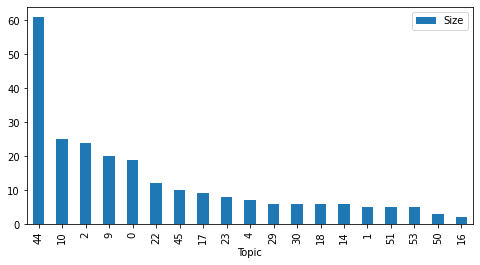

In [33]:
topic_sizes = utils.extract_topic_sizes(docs_df)
topic_sizes.set_index("Topic").plot(kind="bar",figsize=(8,4))

In [35]:
docs_df.head(1)

,Doc,Topic,Doc_ID,Raw_Doc,mix,kicker_headline,text_ne,seo_title_ne
0,coronakrise kurzarbeit steigende arbeitslosigkeit millionen haben gerade angst um ihre finanzen ein großer kostenblock für viele sind versicherungen welche ist wichtig welche kann man sich sparen lesen sie nur mit bild plus die große versicherungsanalyse,22,01041edd835d23b5fc1da3f45bd9eecee20712902612a075ee68873bcdfba708,"Corona-Krise, Kurzarbeit, steigende Arbeitslosigkeit: Millionen haben gerade Angst um ihre Finanzen. Ein großer Kostenblock für viele sind Versicherungen. Welche ist wichtig, welche kann man sich sparen? Lesen Sie nur mit BILD plus die große Versicherungs-Analyse!","Die große Analyse - Welche Versicherung muss sein, welche ist Quatsch? *** BILDplus Inhalt *** -Wirtschaft -Bild.de","[{""entities"":[{""mentions"":[{""text"":{""content"":""Analyse"",""beginOffset"":11},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Analyse"",""type"":""OTHER"",""salience"":0.4083549380302429,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Quatsch"",""beginOffset"":61},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Quatsch"",""type"":""OTHER"",""salience"":0.3228294253349304,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Versicherung"",""beginOffset"":26},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Versicherung"",""type"":""ORGANIZATION"",""salience"":0.26881563663482666,""sentiment"":null}],""language"":""de""},null,null]","[{""entities"":[{""mentions"":[{""text"":{""content"":""Kurzarbeit"",""beginOffset"":14},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Kurzarbeit"",""type"":""OTHER"",""salience"":0.29490000009536743,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Arbeitslosigkeit"",""beginOffset"":36},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Arbeitslosigkeit"",""type"":""OTHER"",""salience"":0.19496002793312073,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Angst"",""beginOffset"":77},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Angst"",""type"":""OTHER"",""salience"":0.11731062084436417,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Finanzen"",""beginOffset"":91},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Finanzen"",""type"":""OTHER"",""salience"":0.11731062084436417,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Corona-Krise"",""beginOffset"":0},""type"":""PROPER"",""sentiment"":null}],""metadata"":{""mid"":""/g/11fr15t15h"",""wikipedia_url"":""https://en.wikipedia.org/wiki/COVID-19_pandemic""},...","[{""entities"":[{""mentions"":[{""text"":{""content"":""Analyse"",""beginOffset"":11},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Analyse"",""type"":""WORK_OF_ART"",""salience"":0.42783594131469727,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Versicherung"",""beginOffset"":28},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Versicherung"",""type"":""ORGANIZATION"",""salience"":0.29629403352737427,""sentiment"":null},{""mentions"":[{""text"":{""content"":""Quatsch"",""beginOffset"":63},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""Quatsch"",""type"":""OTHER"",""salience"":0.1511181890964508,""sentiment"":null},{""mentions"":[{""text"":{""content"":""BILDplus Inhalt *** -Wirtschaft -Bild.de"",""beginOffset"":76},""type"":""COMMON"",""sentiment"":null}],""metadata"":{},""name"":""BILDplus Inhalt *** -Wirtschaft -Bild.de"",""type"":""OTHER"",""salience"":0.12475184351205826,""sentiment"":null}],""language"":""de""},null,null]"


### Let's see how cluster-based TF-IDF selects words describing clusters

# TFIDF on Text



In [36]:
tf_idf, count = utils.c_tf_idf(docs_per_topic.Doc.values, m=len(pdf),ngram_range=(1,1),remove_stop_words=True)
top_n_words = utils.extract_top_n_words_per_topic(tf_idf, count, docs_per_topic.reset_index(), n=20)
top_6_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:6]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])
top_6_words_per_topic["Topic"]=top_6_words_per_topic["Topic"].apply(int)
topic_sizes = utils.extract_topic_sizes(docs_df)
top_6_words_per_topic=top_6_words_per_topic.set_index("Topic")
pd.set_option('display.max_colwidth', 1000)

top_6_words_per_topic


,top_n_words
Topic,
0,zverev | open | us | thiem | finale | alexander
1,kalifornien | brände | oregon | held | feuer | flammen
2,moria | lesbos | flüchtlinge | aufnahme | seehofer | lager
4,brady | playbook | nfl | teams | bay | tampa
9,verletzt | polizei | fahrer | verletzungen | unfall | auto
10,vettel | formel | aston | martin | ferrari | rennen
14,reisen | urlaub | reisewarnungen | risikogebiet | welche | auswärtige
16,wendt | krokodil | landratsamt | existenz | schulz | gero
17,lotta | hunde | hündin | tiere | franziska | kleine


## Let's apply FLAIR-based NER on:
- Raw documents joined together
- Headline + SEO title joined together 

In [65]:
ner_labels = ner_article(docs_per_topic["Raw_Doc"].loc[0])
print(collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower()]).most_common()[:6])



[('Zverev', 66), ('US Open', 51), ('Alexander Zverev', 36), ('Thiem', 24), ('New York', 22), ('Boris Becker', 16)]


In [13]:
ner_labels = ner_article(docs_per_topic["mix"].loc[0])
print(collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower()]).most_common()[:6])

[('US Open', 12), ('Alexander Zverev', 7), ('Dominic Thiem', 5), ('Zverev', 3), ('Alex Zverev', 2), ('Mischa', 2)]


In [ ]:
ctrs=[]
start_time = time.time()

for topic in docs_per_topic.index.values:
    ner_labels = ner_article(docs_per_topic["Raw_Doc"].loc[topic])
    ctrs.append(collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower() ]).most_common()[:10])
print("--- Documnets NER encoded %s seconds ---" % (time.time() - start_time))

In [ ]:
dict_with_top_words = {k:v  for k,v in  zip(docs_per_topic.index.values,ctrs)}    
dict_with_top_words[6]

In [ ]:
ctrs=[]

start_time = time.time()

for topic in docs_per_topic.index.values: # Go over topic labels 
    ner_labels = ner_article(docs_per_topic["mix"].loc[topic])
    counted_word_occurances = collections.Counter([x["text"] for x in ner_labels if "bild" not in x["text"].lower() ]).most_common()[:10]
    ctrs.append(counted_word_occurances)
print("--- Titles NER encoded in %s seconds ---" % (time.time() - start_time))
    

In [ ]:
dict_with_top_words = {k:v  for k,v in  zip(topic_sizes["Topic"].values,ctrs)}    


pd.DataFrame(zip(topic_sizes["Topic"].values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")

# Using NER from Google API 

Now for every article let's load list of entities from Google NLP

In [37]:

def parse_google_named_entities(json_obj,deduplicate=False):
    #Parse objets and deduplicate list of them 
    parse_named_entity = lambda ne: {"text":ne["name"],"type":ne["type"]}
    list_of_objects = [parse_named_entity(ne) for ne in json.loads(json_obj)[0]["entities"] if "bild" not in ne["name"].lower() ]
    if not deduplicate:
        return dedupe(list_of_objects)
    else:
        return list_of_objects
    

In [38]:
article_id = 2
parse_google_named_entities(labeled.kicker_headline[article_id]),parse_google_named_entities(labeled.seo_title_ne[article_id])


([{'text': 'Fahrer', 'type': 'PERSON'},
  {'text': 'Führerschein', 'type': 'OTHER'},
  {'text': '510-PS-Flitzerkracht', 'type': 'EVENT'},
  {'text': 'Baum', 'type': 'OTHER'},
  {'text': '510', 'type': 'NUMBER'}],
 [{'text': 'Unfall', 'type': 'EVENT'},
  {'text': 'Hilden', 'type': 'LOCATION'},
  {'text': '510-PS-Flitzer', 'type': 'CONSUMER_GOOD'},
  {'text': '510', 'type': 'NUMBER'}])

In [58]:
ctrs=[]
for topic in docs_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]
    seo_title_entities = [elem["text"] for elem in docs_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]*2
    kicker_headline_entities = [elem["text"] for elem in docs_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]*3
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:8]

    #counted_word_occurances = collections.Counter([elem["text"] for elem in docs_per_topic.set_index("Topic").loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON"]).most_common()[:10]
    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(docs_per_topic.index.values,ctrs)}    


cluster_labels_google = pd.DataFrame(zip(docs_per_topic.index.values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")

In [69]:

word_embedding_model = models.Transformer(
    'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb')


max_pooling = False

embeddings = modeling.get_sentence_embeddings(X.text.values,word_embedding_model,max_pooling)

N_COMPONENTS=256
alpha=0.825
min_cluster_size=3
min_samples=3
n_neighbors=46

results,cluster_labels = modeling.cluster_and_reduce(embeddings,n_components_clustering=N_COMPONENTS,
                                                                             min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)


--- Embedding dimension 768
--- 239 Documnets encoded 21.636041164398193 seconds ---
>> Reducing dimensionality from 768 to 256 ...
>> Clustering...
>> --- Done in 3.1 seconds ---


Outliers: 0 | Clustered: 239 | 1.0 
 Cluster count: 19 


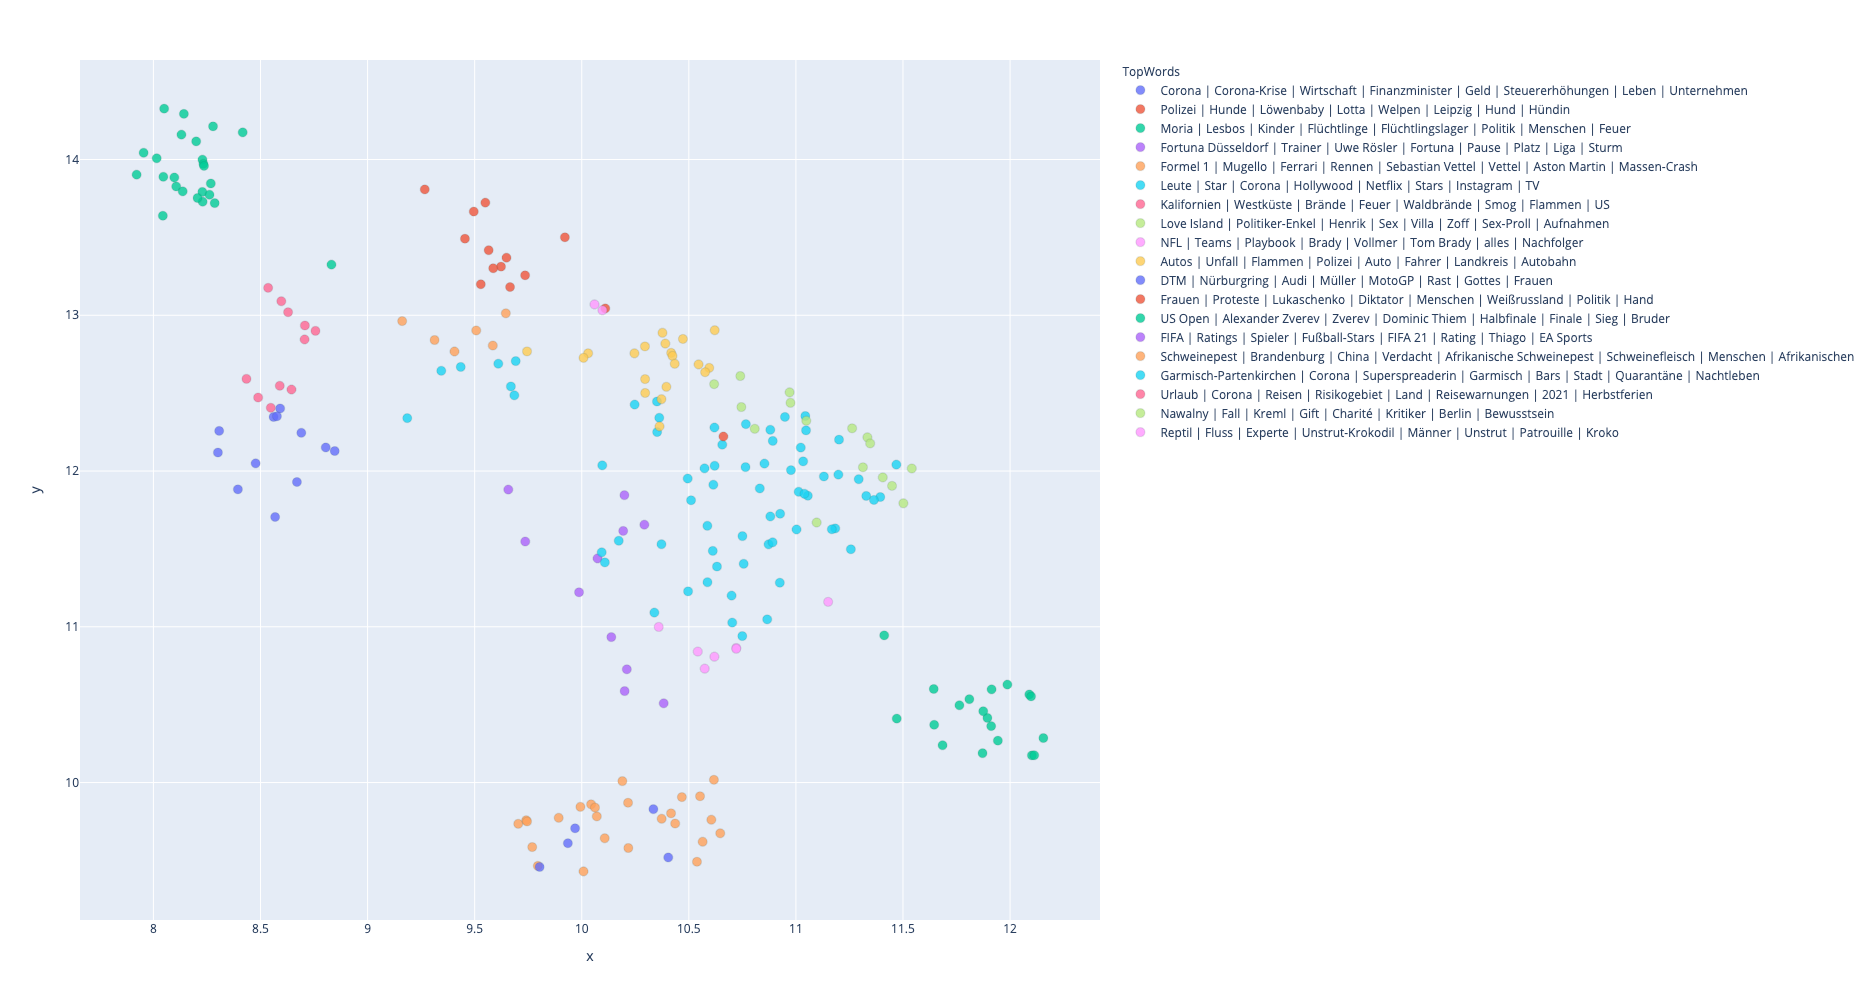

In [70]:
results = utils.link_to_raw_data(results,X,y.values)
                        
results["labels"] = results.labels.apply(int)
results=pd.merge(results,cluster_labels_google.reset_index(),left_on="labels",right_on = "Topic")
fig = px.scatter(results, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords"], color="TopWords",
                 opacity=0.8)
fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()